PROGRAM TO ANALYZE THE IMPORTANCE OF CERTAIN FEATURES OF USED CARS.  THE DATA ORIGINALLY FROM KAGGLE WAS PROVIDED BY U OF BERKELY

CONTAINS DATA EXPLORATION, CLEANSING, FEATURE ENGINEERING AND SELECTION, MODEL SELECTION, AND MODEL INTERPRETATION

In [419]:
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings 
from datetime import date
from scipy import stats 
filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector


EXPLORE DATA

In [422]:
#load data and info
car = pd.read_csv('data/vehicles.csv')
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [423]:
#Look for null values, size is missing 71% of values consider dropping
car.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [426]:
#Look for duplicated data, no data is duplicative
car.duplicated().sum()

0

In [428]:
#Count the number of each value and determine need for data cleansing

#car['id'].value_counts() uniqueID for dataset
#car['price'].value_counts() #continuous
#car['year'].value_counts() # 80 dominant ~64%, good split
#car['odometer'].value_counts() #  may consider log, wide range of numbers here

#car['manufacturer'].value_counts() #clean
#car['model'].value_counts() # how do I want to normalize this text
#car['region'].value_counts() # rename spokane / coeur d'alene 
#car['VIN'].value_counts() #may consider dropping

#car['condition'].value_counts() # consider one hot encoding
#car['cylinders'].value_counts() #8 values
#car['fuel'].value_counts() # consider for ohe, five values
#car['title_status'].value_counts() # six values, consider for OHE
#car['transmission'].value_counts() # three types
#car['drive'].value_counts() # 4wd, fwd, rwd consider for OHE
#car['size'].value_counts() # four types, consider for OHE
#car['type'].value_counts() ## 13 types, clean
#car['paint_color'].value_counts() ## clean, twelve values


DATA CLEANSING = drop impute, duplicates

In [431]:
#clean transmission value
car.dropna(subset=['transmission'], inplace=True)

In [433]:
#drop type as it cannot be imputed with mode
car.dropna(subset=['type'], inplace=True)

In [435]:
#try impute with mode as it reaches across types
car['manufacturer'].fillna(car['manufacturer'].mode()[0], inplace=True)

In [437]:
#try impute with mode as it reaches across types
car['fuel'].fillna(car['fuel'].mode()[0], inplace=True)

In [439]:
#check values
car.isnull().sum()

id                   0
region               0
price                0
year              1014
manufacturer         0
model             2892
condition       112182
cylinders       110840
fuel                 0
odometer          3216
title_status      7104
transmission         0
VIN              95990
drive            68927
size            215833
type                 0
paint_color      63676
state                0
dtype: int64

In [441]:
#Used Car Price Trends, top average price is a Lamboghini at $222K.  Looking at all cars under than price

bad_prices = car[car.price>222000]
bad_prices.sort_values('price')

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
127596,7316889794,hawaii,225995,2016.0,porsche,911,NaN,6 cylinders,gas,159.0,clean,other,WP0AF2A97GS192995,rwd,NaN,coupe,purple,hi
8901,7310125042,flagstaff / sedona,229500,2018.0,ferrari,488 spider,NaN,8 cylinders,gas,7910.0,salvage,automatic,ZFF80AMA9J0233387,rwd,sub-compact,convertible,red,az
315274,7310167113,east oregon,229500,2018.0,ferrari,488 spider,NaN,8 cylinders,gas,7910.0,salvage,automatic,ZFF80AMA9J0233387,rwd,sub-compact,convertible,red,or
352992,7310174586,clarksville,229500,2018.0,ferrari,488 spider,NaN,8 cylinders,gas,7910.0,salvage,automatic,ZFF80AMA9J0233387,rwd,sub-compact,convertible,red,tn
415796,7306494891,appleton-oshkosh-FDL,229500,2019.0,ford,Lamborghini Urus,NaN,8 cylinders,gas,32922.0,clean,automatic,ZPBUA1ZL1KLA02237,4wd,compact,SUV,white,wi
9080,7306378728,flagstaff / sedona,229500,2019.0,ford,Lamborghini Urus,NaN,8 cylinders,gas,32922.0,clean,automatic,ZPBUA1ZL1KLA02237,4wd,compact,SUV,white,az
409575,7316325002,seattle-tacoma,239900,2018.0,porsche,911 gt3 touring,NaN,NaN,other,4224.0,clean,manual,WP0AC2A96JS176044,rwd,NaN,other,silver,wa
324462,7316254013,portland,239900,2018.0,porsche,911 gt3 touring,NaN,NaN,other,4224.0,clean,manual,WP0AC2A96JS176044,rwd,NaN,other,silver,or
16684,7310897583,tucson,239995,2017.0,ferrari,488 gtb,NaN,8 cylinders,gas,6012.0,clean,automatic,ZFF79ALA5H0227406,rwd,NaN,coupe,red,az
14950,7314851682,tucson,239995,2017.0,ferrari,488 gtb,NaN,8 cylinders,gas,6450.0,clean,automatic,ZFF79ALA5H0227406,rwd,NaN,coupe,red,az


In [443]:
#drop data of prices that are too large, 759 rows
car_clean = car.drop(index=bad_prices.index)

In [445]:
#check numerics
car_clean.describe()

,id,price,year,odometer
count,3.321110e+05,332111.000000,331097.000000,3.288950e+05
mean,7.311444e+09,18256.155481,2011.975817,9.073983e+04
std,4.390599e+06,15333.995979,8.534440,1.722126e+05
min,7.301583e+09,0.000000,1900.000000,0.000000e+00
25%,7.308053e+09,6500.000000,2009.000000,3.442500e+04
50%,7.312456e+09,14999.000000,2014.000000,7.940700e+04
75%,7.315236e+09,27590.000000,2017.000000,1.273000e+05
max,7.317101e+09,220000.000000,2022.000000,1.000000e+07


In [447]:
#consider cars from 2014 and after as modern vehicles are radically different
car_clean_2014 = car_clean.query('year > 2014')
car_clean_2014.count()

id              152873
region          152873
price           152873
year            152873
manufacturer    152873
model           152058
condition        95586
cylinders        85959
fuel            152873
odometer        151550
title_status    149547
transmission    152873
VIN             128778
drive           115514
size             34789
type            152873
paint_color     119159
state           152873
dtype: int64

FEATURE ENGINEERING = age from year, log odometer to handle skew

In [450]:
#Create a car age field

car_clean_2014['age'] = 2024 - car['year']
print(car_clean_2014['age'])

29        4.0
30        7.0
33        8.0
34        5.0
35        8.0
         ... 
426875    5.0
426876    4.0
426877    4.0
426878    6.0
426879    5.0
Name: age, Length: 152873, dtype: float64


In [452]:
#Odometer imputation
car_clean_2014['odometer'].fillna(car_clean['odometer'].mean(), inplace=True)
car_clean_2014['odometer'] = car_clean['odometer'].apply(lambda x: x if x>0 else 1)

In [454]:
#drop nulls
car_clean_2014.dropna(subset=['odometer'], inplace=True)

In [456]:
#Change to a log value
car_clean_2014['odometer_log'] = np.log(car_clean['odometer'])

In [458]:
#drop odometer_log nulls
car_clean_2014.dropna(subset=['odometer_log'], inplace=True)

In [460]:
#Check Values
car_clean_2014.isnull().sum()

id                   0
region               0
price                0
year                 0
manufacturer         0
model              815
condition        56688
cylinders        66085
fuel                 0
odometer             0
title_status      3326
transmission         0
VIN              23402
drive            37151
size            117011
type                 0
paint_color      33057
state                0
age                  0
odometer_log         0
dtype: int64

EXPLORE DATA AND FEATURE SELECTION = correlation analysis, visualizations of prices across different categories

In [463]:
#select variables.  The following are ways to describe cars, where variables like VIN and ID are unique
car_clean_2014 = car_clean_2014[['price', 'age', 'odometer_log', 'fuel', 'transmission', 'type', 'manufacturer']]

In [465]:
car_clean_2014.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151550 entries, 29 to 426879
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         151550 non-null  int64  
 1   age           151550 non-null  float64
 2   odometer_log  151550 non-null  float64
 3   fuel          151550 non-null  object 
 4   transmission  151550 non-null  object 
 5   type          151550 non-null  object 
 6   manufacturer  151550 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 9.2+ MB


In [467]:
#Encode categorical and scale numerical
car_clean_2014 = pd.get_dummies(car_clean_2014, columns=['fuel', 'transmission', 'type', 'manufacturer'], drop_first=True)

In [469]:
#Scale numeric variables
scaler=StandardScaler()

car_clean_2014[['price', 'age']] = scaler.fit_transform(car_clean_2014[['price', 'age']])

Text(0.5, 1.0, 'Total Records by Price')

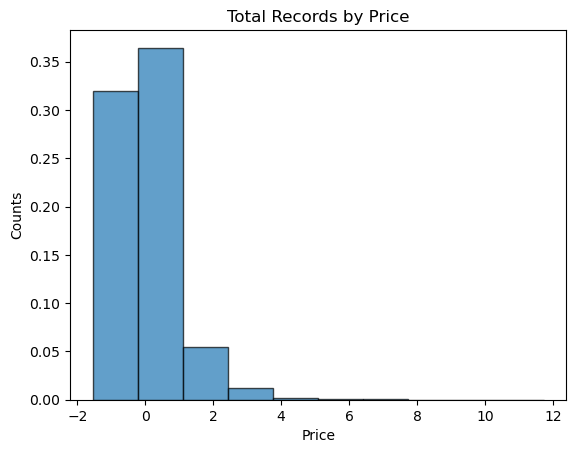

In [471]:
plt.hist(car_clean_2014['price'], 10, density=1, alpha=0.7, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Counts')

plt.title('Total Records by Price')

                        price       age  odometer_log  transmission_manual  \
price                1.000000 -0.268682     -0.229097            -0.026866   
age                 -0.268682  1.000000      0.587493             0.037724   
odometer_log        -0.229097  0.587493      1.000000            -0.006028   
transmission_manual -0.026866  0.037724     -0.006028             1.000000   
transmission_other   0.160567 -0.229627     -0.292661            -0.101474   
fuel_electric        0.010479 -0.018251     -0.039775            -0.009256   
fuel_hybrid         -0.026841 -0.007319     -0.000542             0.021175   
fuel_gas            -0.186350  0.053021      0.027860             0.032353   
fuel_other           0.094797 -0.091920     -0.090507            -0.032118   

                     transmission_other  fuel_electric  fuel_hybrid  fuel_gas  \
price                          0.160567       0.010479    -0.026841 -0.186350   
age                           -0.229627      -0.018251   

Text(0.5, 1.0, 'Correlation Heatmap UsedCar')

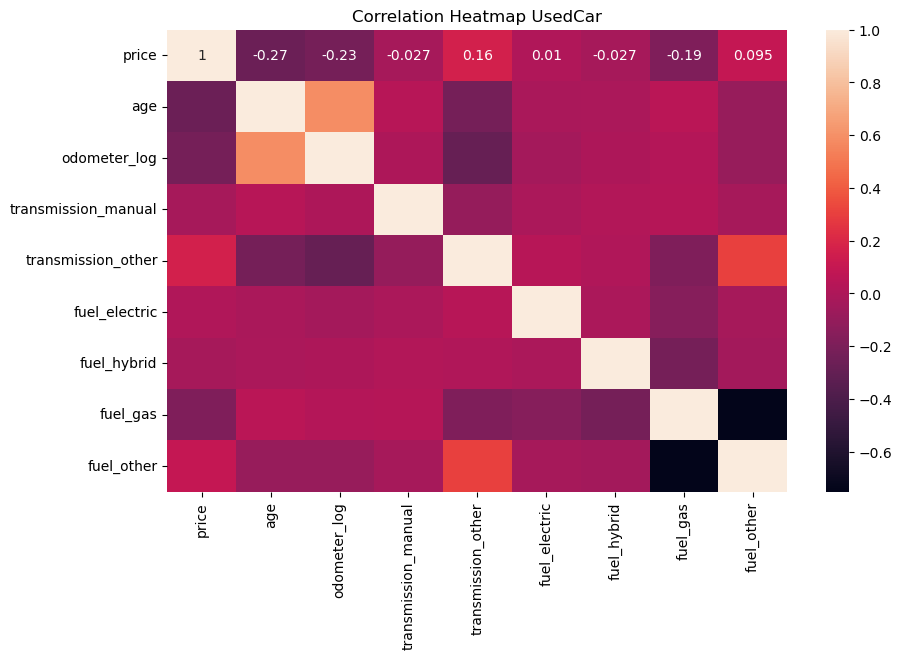

In [473]:
#Explore a correlation of price with age, odometer, transmissions and fuel types
print(car_clean_2014[['price', 'age', 'odometer_log', 'transmission_manual', 'transmission_other', 'fuel_electric', 'fuel_hybrid', 'fuel_gas', 'fuel_other']].corr(numeric_only=True))
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(car_clean_2014[['price', 'age', 'odometer_log','transmission_manual', 'transmission_other', 'fuel_electric', 'fuel_hybrid', 'fuel_gas', 'fuel_other']].corr(numeric_only=True), annot=True)
heatmap.set_title('Correlation Heatmap UsedCar')

                     price  type_bus  type_convertible  type_coupe  \
price             1.000000 -0.016112          0.054881    0.078448   
type_bus         -0.016112  1.000000         -0.002877   -0.006575   
type_convertible  0.054881 -0.002877          1.000000   -0.023477   
type_coupe        0.078448 -0.006575         -0.023477    1.000000   
type_hatchback   -0.093435 -0.007264         -0.025938   -0.059277   
type_mini-van    -0.042192 -0.002474         -0.008836   -0.020192   
type_offroad      0.006265 -0.000619         -0.002210   -0.005050   
type_other        0.084403 -0.008954         -0.031973   -0.073069   
type_pickup       0.233030 -0.011737         -0.041910   -0.095780   
type_sedan       -0.224592 -0.016340         -0.058348   -0.133345   
type_truck        0.135921 -0.009509         -0.033955   -0.077600   
type_van         -0.011736 -0.004724         -0.016867   -0.038547   
type_wagon       -0.069101 -0.004953         -0.017688   -0.040422   

                  t

Text(0.5, 1.0, 'Correlation Heatmap UsedCar')

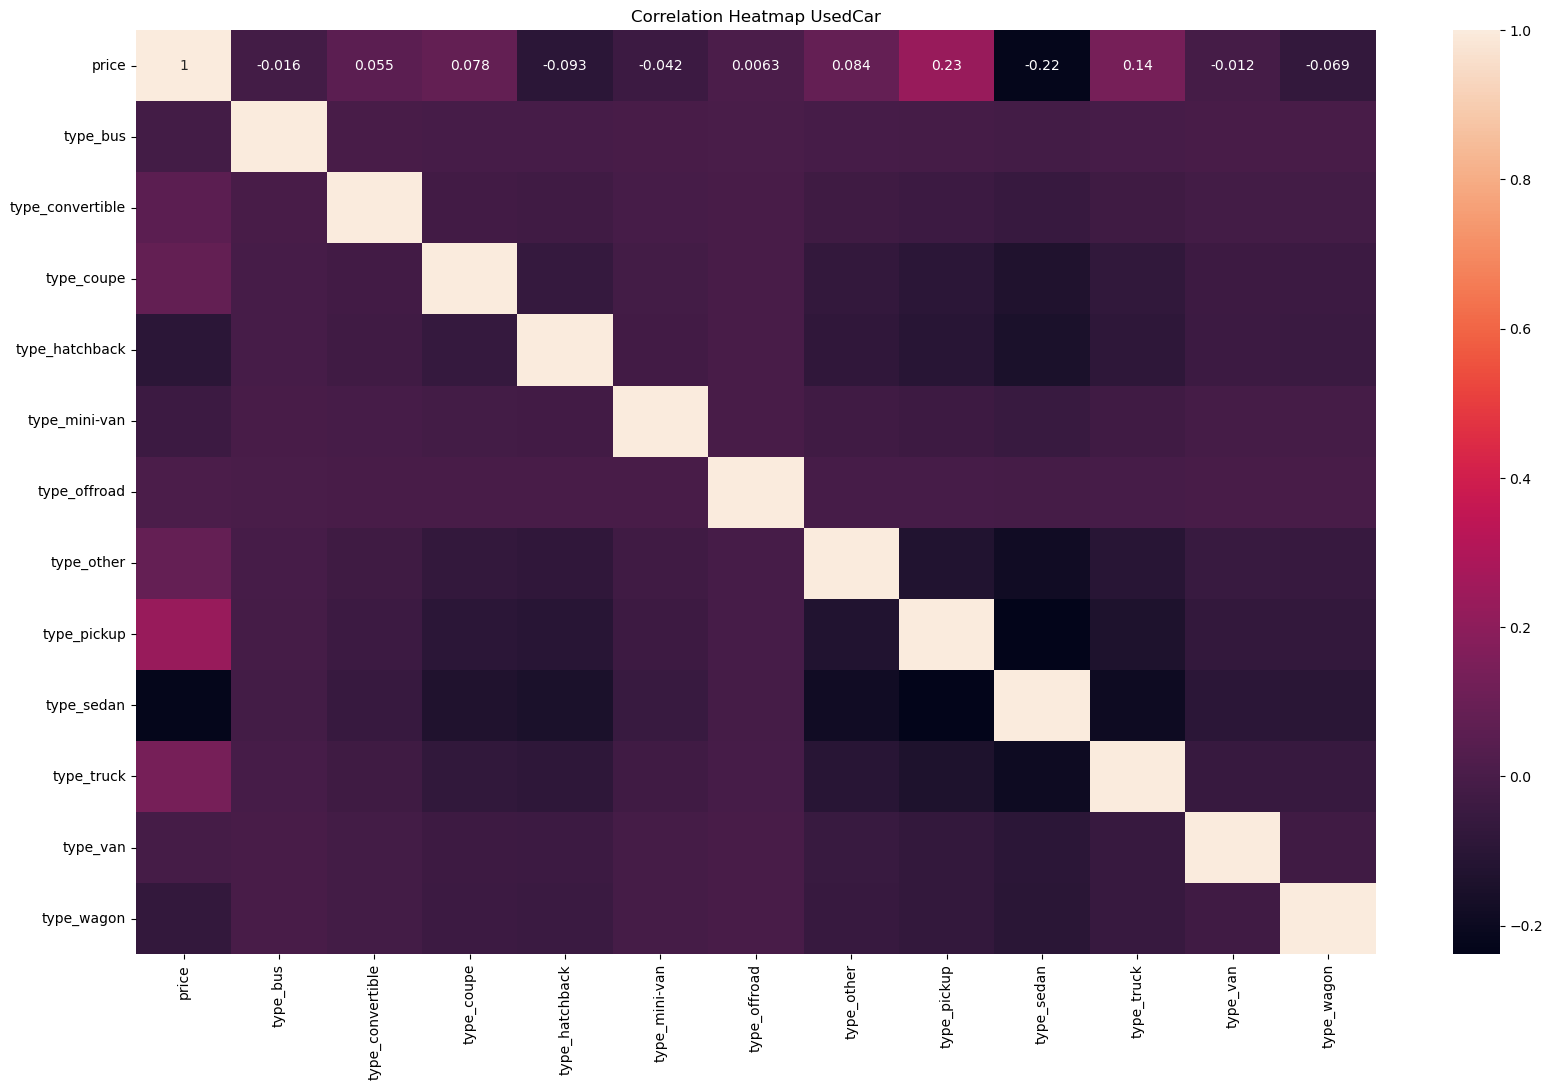

In [475]:
#Explore a correlation of price with type of cars
print(car_clean_2014[['price', 'type_bus', 'type_convertible', 'type_coupe', 'type_hatchback', 'type_mini-van', 'type_offroad', 'type_other', 'type_pickup', 'type_sedan', 'type_truck', 'type_van', 'type_wagon']].corr(numeric_only=True))
plt.figure(figsize=(20,12))
heatmap = sns.heatmap(car_clean_2014[['price', 'type_bus', 'type_convertible', 'type_coupe', 'type_hatchback', 'type_mini-van', 'type_offroad', 'type_other', 'type_pickup', 'type_sedan', 'type_truck', 'type_van', 'type_wagon']].corr(numeric_only=True), annot=True)
heatmap.set_title('Correlation Heatmap UsedCar')



                                 price       age  odometer_log  fuel_electric  \
price                         1.000000 -0.268682     -0.229097       0.010479   
age                          -0.268682  1.000000      0.587493      -0.018251   
odometer_log                 -0.229097  0.587493      1.000000      -0.039775   
fuel_electric                 0.010479 -0.018251     -0.039775       1.000000   
fuel_gas                     -0.186350  0.053021      0.027860      -0.158388   
fuel_hybrid                  -0.026841 -0.007319     -0.000542      -0.009651   
fuel_other                    0.094797 -0.091920     -0.090507      -0.031828   
transmission_manual          -0.026866  0.037724     -0.006028      -0.009256   
transmission_other            0.160567 -0.229627     -0.292661       0.035194   
type_bus                     -0.016112 -0.005279     -0.013438       0.000537   
type_convertible              0.054881  0.018089     -0.037629      -0.008298   
type_coupe                  

Text(0.5, 1.0, 'Correlation Heatmap UsedCar')

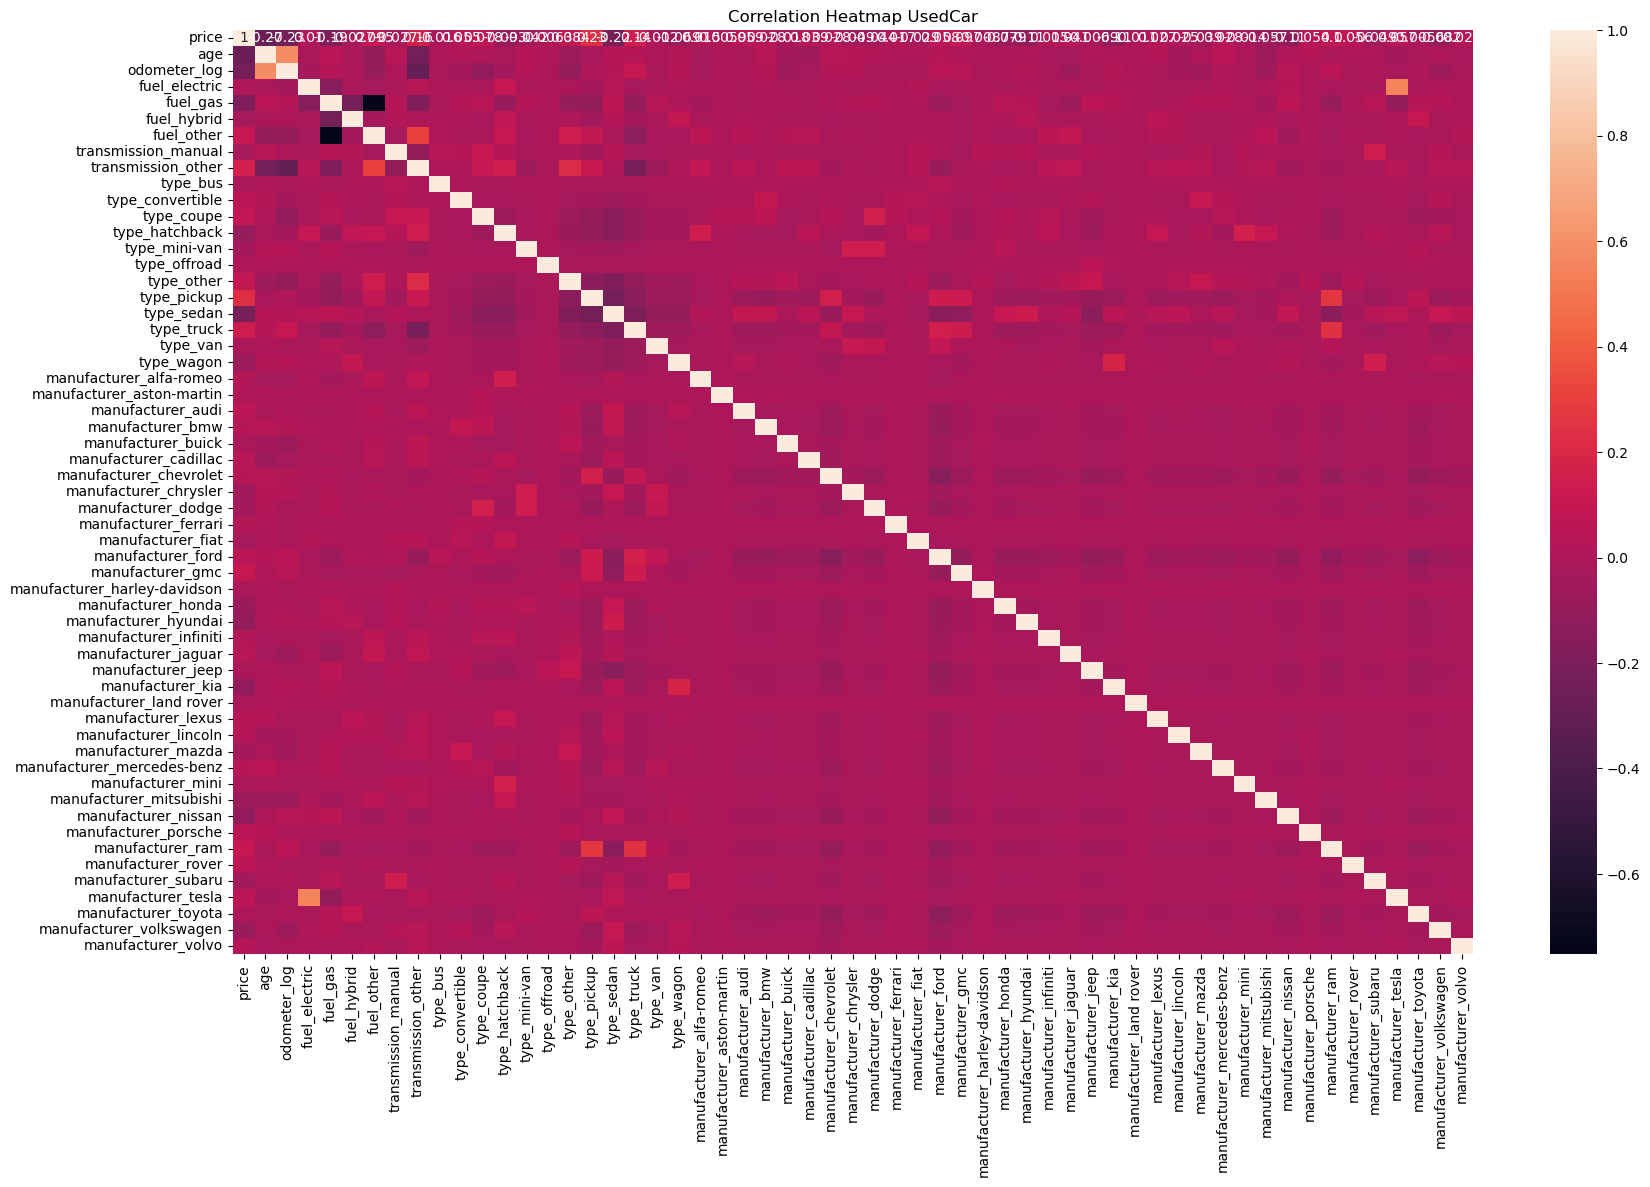

In [477]:
#Explore a correlation of numeric values for all
print(car_clean_2014.corr(numeric_only=True))
plt.figure(figsize=(20,12))
heatmap = sns.heatmap(car_clean_2014.corr(numeric_only=True), annot=True)
heatmap.set_title('Correlation Heatmap UsedCar')

In [479]:
#Handle infinities from logs
#print(np.isinf(car_clean_2014).sum())
inf_rows = car_clean_2014[np.isinf(car_clean_2014).any(axis=1)]
print("Rows with inf :", inf_rows)

Rows with inf :            price       age  odometer_log  fuel_electric  fuel_gas  \
1192   -1.542083  0.848374          -inf          False     False   
4536   -1.542083  1.463945          -inf          False     False   
9561   -1.542083  1.463945          -inf          False     False   
13533  -1.542083  1.463945          -inf          False     False   
15239   1.473432  0.848374          -inf          False     False   
...          ...       ...           ...            ...       ...   
417684 -1.542083  1.463945          -inf          False     False   
418265 -1.542083  1.463945          -inf          False     False   
421504 -1.542083  1.463945          -inf          False     False   
421846 -1.542083  0.848374          -inf          False     False   
426638 -1.542083  1.463945          -inf          False     False   

        fuel_hybrid  fuel_other  transmission_manual  transmission_other  \
1192          False       False                False                True   
453

In [481]:
#replace and drop infinity records
car_clean_2014 = car_clean_2014.replace([np.inf, -np.inf], np.nan).dropna()

In [483]:
#check records
car_clean_2014.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150973 entries, 29 to 426879
Data columns (total 57 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   price                         150973 non-null  float64
 1   age                           150973 non-null  float64
 2   odometer_log                  150973 non-null  float64
 3   fuel_electric                 150973 non-null  bool   
 4   fuel_gas                      150973 non-null  bool   
 5   fuel_hybrid                   150973 non-null  bool   
 6   fuel_other                    150973 non-null  bool   
 7   transmission_manual           150973 non-null  bool   
 8   transmission_other            150973 non-null  bool   
 9   type_bus                      150973 non-null  bool   
 10  type_convertible              150973 non-null  bool   
 11  type_coupe                    150973 non-null  bool   
 12  type_hatchback                150973 non-null  b

In [485]:
#Lasso Regression for feature selection
X = car_clean_2014.drop('price', axis=1)
y = car_clean_2014['price']

In [487]:
#run lasso to see non zero coef to highlight important features
lasso = Lasso(alpha=0.1)
lasso.fit(X,y)

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coef': lasso.coef_
})


coef_df.head()

,Feature,Coef
0,age,-0.123360
1,odometer_log,-0.061129
2,fuel_electric,0.000000
3,fuel_gas,-0.000000
4,fuel_hybrid,-0.000000


MODEL SELECTION & TRAINING = train, split, mae and mse, cross validation, run grid search hyperparameter tuning

In [490]:
#Split training data and check lengths
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

print("length of X_train:", len(X_train))
print("length of y_train:", len(y_train))
print("length of X_test:", len(X_test))
print("length of y_test:", len(y_test))

length of X_train: 113229
length of y_train: 113229
length of X_test: 37744
length of y_test: 37744


In [492]:
#Run a grid search for optimal hyperparameters, Ridge selected with best performance above

ridge_params = {'alpha': [0.1, 1.0, 10.0, 100]}

ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5)

ridge_grid.fit(X_train, y_train)

print("Best Ridge Params:", ridge_grid.best_params_)

Best Ridge Params: {'alpha': 10.0}


In [506]:
#Run a grid search for optimal hyperparameters, Ridge selected with best performance above

lasso_params = {'alpha': [0.01, 0.1, 1.0, 10.0]}

lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=5)

lasso_grid.fit(X_train, y_train)

print("Best Ridge Params:", lasso_grid.best_params_)

Best Ridge Params: {'alpha': 0.01}


In [508]:
#Train three type of regression models with best hyperparameters
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha = 10.0),
    "Lasso": Lasso(alpha=0.01)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} model trained.")



Linear Regression model trained.
Ridge model trained.
Lasso model trained.


In [512]:
#Run scores and Cross Validation

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_RMSE = np.sqrt(-cv_scores)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"{name} Model:MSE {mse} ")
    print(f"Cross Validation RMSE: {cv_RMSE.mean():.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R Squared: {r2:.4f}")
    


Linear Regression Model:MSE 0.6722066567560562 
Cross Validation RMSE: 0.8350
Test RMSE: 0.8199
Test R Squared: 0.3087
Ridge Model:MSE 0.6715142970795301 
Cross Validation RMSE: 0.8348
Test RMSE: 0.8195
Test R Squared: 0.3094
Lasso Model:MSE 0.7470723530293074 
Cross Validation RMSE: 0.8798
Test RMSE: 0.8643
Test R Squared: 0.2317


In [513]:
  # SequentialFeatureSelection using the Lasso to select 4 features to see if there is any variance from previous untrained lasso
#Ridge only showed age
selector = ''
best_features = ''
best_features_df = ''

selector = SequentialFeatureSelector(Lasso(), n_features_to_select=4)
best_features = selector.fit_transform(X_train, y_train)
best_features_df = pd.DataFrame(best_features, columns = selector.get_feature_names_out())

# ANSWER CHECK
best_features_df.head()

,age,odometer_log,fuel_electric,fuel_gas
0,-0.382767,10.748712,0.0,0.0
1,0.848374,10.241352,0.0,1.0
2,-0.382767,11.031659,0.0,1.0
3,-0.382767,10.269276,0.0,1.0
4,0.848374,11.356237,0.0,1.0


In [515]:
#Output Lasso coefficients

coef_list_LassoSeq = []
coef_list_LassoSeq.append(list(lasso.coef_))

print('We have the following coefficients:')
list(zip(X_train.columns, coef_list_LassoSeq[-1]))

We have the following coefficients:


[('age', -0.12335996716956853),
 ('odometer_log', -0.06112904856199687),
 ('fuel_electric', 0.0),
 ('fuel_gas', -0.0),
 ('fuel_hybrid', -0.0),
 ('fuel_other', 0.0),
 ('transmission_manual', -0.0),
 ('transmission_other', 0.0),
 ('type_bus', -0.0),
 ('type_convertible', 0.0),
 ('type_coupe', 0.0),
 ('type_hatchback', -0.0),
 ('type_mini-van', -0.0),
 ('type_offroad', 0.0),
 ('type_other', 0.0),
 ('type_pickup', 0.0),
 ('type_sedan', -0.0),
 ('type_truck', 0.0),
 ('type_van', -0.0),
 ('type_wagon', -0.0),
 ('manufacturer_alfa-romeo', 0.0),
 ('manufacturer_aston-martin', 0.0),
 ('manufacturer_audi', 0.0),
 ('manufacturer_bmw', 0.0),
 ('manufacturer_buick', -0.0),
 ('manufacturer_cadillac', 0.0),
 ('manufacturer_chevrolet', 0.0),
 ('manufacturer_chrysler', -0.0),
 ('manufacturer_dodge', -0.0),
 ('manufacturer_ferrari', 0.0),
 ('manufacturer_fiat', -0.0),
 ('manufacturer_ford', 0.0),
 ('manufacturer_gmc', 0.0),
 ('manufacturer_harley-davidson', -0.0),
 ('manufacturer_honda', -0.0),
 ('manuf

In [516]:
model_1_R = ''
model_1_R_coefs = ''

### BEGIN SOLUTION
model_1_R = Ridge().fit(X_train, y_train)
model_1_R_coefs = model_1_R.coef_

# Answer check
print(f'Ridge Coefs: {np.round(model_1_R_coefs, 2)}')

Ridge Coefs: [-0.18 -0.08 -0.68 -0.69 -0.66 -0.58  0.07  0.16 -0.67  0.67  0.37 -0.29
 -0.07  0.44  0.24  0.65 -0.25  0.49  0.12 -0.14  0.23  0.56  0.37  0.18
 -0.31  0.32 -0.2  -0.22 -0.23  2.23 -0.58 -0.16  0.02 -1.26 -0.33 -0.47
  0.06  0.19 -0.11 -0.52 -0.62  0.32  0.18 -0.44  0.23 -0.11 -0.67 -0.46
  1.13 -0.28  0.71 -0.19  0.95 -0.15 -0.45  0.3 ]


In [517]:
coef_list_Ridge = []
coef_list_Ridge.append(list(model_1_R.coef_))

print('We have the following coefficients:')
list(zip(X_train.columns, coef_list_Ridge[-1]))

We have the following coefficients:


[('age', -0.18495509639669339),
 ('odometer_log', -0.0832107289459244),
 ('fuel_electric', -0.676899517908482),
 ('fuel_gas', -0.6913528231524896),
 ('fuel_hybrid', -0.6631584888353407),
 ('fuel_other', -0.5813083882273504),
 ('transmission_manual', 0.06985573138408166),
 ('transmission_other', 0.15780569274725464),
 ('type_bus', -0.674836275516982),
 ('type_convertible', 0.6736112312701691),
 ('type_coupe', 0.36891831843103684),
 ('type_hatchback', -0.28817360156642235),
 ('type_mini-van', -0.07374726023583025),
 ('type_offroad', 0.4387895857460536),
 ('type_other', 0.23744974050189405),
 ('type_pickup', 0.6511421996844503),
 ('type_sedan', -0.2481989327738708),
 ('type_truck', 0.49185849302511686),
 ('type_van', 0.12471804379452989),
 ('type_wagon', -0.13682812427639188),
 ('manufacturer_alfa-romeo', 0.2321134476469845),
 ('manufacturer_aston-martin', 0.5604476701565975),
 ('manufacturer_audi', 0.36999017073868445),
 ('manufacturer_bmw', 0.18326420417103215),
 ('manufacturer_buick', 

In [518]:

train_predsR = ''
test_predsR = ''
train_mseR = ''
test_mseR = ''

train_predsR = model_1_R.predict(X_train)
test_predsR = model_1_R.predict(X_test)
train_mseR = mean_squared_error(y_train, train_predsR)
test_mseR = mean_squared_error(y_test, test_predsR)


# Answer check
print(f'Train MSE Ridge: {train_mseR: .2f}')
print(f'Test MSE Ridge: {test_mseR: .2f}')


Train MSE Ridge:  0.70
Test MSE Ridge:  0.67


MODEL INTERPRETATION


In [520]:
best_model_ridge = ridge_grid.best_estimator_
best_model_ridge.fit(X_train, y_train)

feature_importance = pd.Series(best_model_ridge.coef_, index=X_train.columns)
print(feature_importance.sort_values(ascending=False))

manufacturer_ferrari            1.272062
manufacturer_porsche            1.094317
manufacturer_tesla              0.911830
manufacturer_rover              0.698404
type_convertible                0.668811
type_pickup                     0.649949
type_truck                      0.491573
type_offroad                    0.372428
type_coupe                      0.369833
manufacturer_audi               0.369817
manufacturer_lexus              0.323835
manufacturer_cadillac           0.320085
manufacturer_volvo              0.300578
manufacturer_aston-martin       0.245096
type_other                      0.236233
manufacturer_mercedes-benz      0.232369
manufacturer_alfa-romeo         0.230313
manufacturer_jaguar             0.185072
manufacturer_lincoln            0.183888
manufacturer_bmw                0.183728
transmission_other              0.157698
type_van                        0.123162
transmission_manual             0.066658
manufacturer_infiniti           0.061707
manufacturer_gmc

Insights and Visualization Recommendations = highlight features, pricing strategies